In [1]:
import logging
import sys
import os

import zipfile

import importlib

from six.moves import urllib
from shutil import copy2

import matplotlib.pyplot as plt

import cv2

import numpy as np

from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

In [15]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 64, 64

In [2]:
def download(url, dest_directory):
    filename = url.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)

    logging.info("Download URL: {}".format(url))
    logging.info("Download DIR: {}".format(dest_directory))

    def _progress(count, block_size, total_size):
                prog = float(count * block_size) / float(total_size) * 100.0
                sys.stdout.write('\r>> Downloading %s %.1f%%' %
                                 (filename, prog))
                sys.stdout.flush()

    filepath, _ = urllib.request.urlretrieve(url, filepath,
                                             reporthook=_progress)
    print()
    return filepath


importlib.reload(logging)
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

# Download KITTI DATA

kitti_data_url = 'https://s3.eu-central-1.amazonaws.com/avg-kitti/data_road.zip'

data_dir = './data'

data_road_zip = './data/data_road.zip'


if not os.path.exists(data_road_zip):
    if kitti_data_url == '':
        logging.error("Data URL for Kitti Data not provided.")
        url = "http://www.cvlibs.net/download.php?file=data_road.zip"
        logging.error("Please visit: {}".format(url))
        logging.error("and request Kitti Download link.")
        logging.error("Rerun scipt using"
                      "'python download_data.py' --kitti_url [url]")
        exit(1)
    if not kitti_data_url[-19:] == 'kitti/data_road.zip':
        logging.error("Wrong url.")
        url = "http://www.cvlibs.net/download.php?file=data_road.zip"
        logging.error("Please visit: {}".format(url))
        logging.error("and request Kitti Download link.")
        logging.error("Rerun scipt using"
                      "'python download_data.py' --kitti_url [url]")
        exit(1)
    else:
        logging.info("Downloading Kitti Road Data.")
        download(kitti_data_url, data_dir)

# Extract and prepare KITTI DATA
logging.info("Extracting kitti_road data.")
zipfile.ZipFile(data_road_zip, 'r').extractall(data_dir)
kitti_road_dir = os.path.join(data_dir, 'data_road/')

#logging.info("Preparing kitti_road data.")

train_txt = "data/train3.txt"
val_txt = "data/val3.txt"
testing_txt = "data/testing.txt"

sys.stdout.flush()

#copy2(train_txt, kitti_road_dir)
#copy2(val_txt, kitti_road_dir)
#copy2(testing_txt, kitti_road_dir)

#logging.info("All data have been downloaded successful.")

INFO:root:Extracting kitti_road data.


value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 0
value 1
centroid, intersection counts 2752 2631


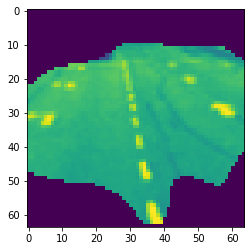

In [37]:
with open(train_txt, 'r') as f:
    for line in f:
        names = line.split()
        #logging.info(names[0])
        #logging.info(names[1])        
        # load the image and apply SLIC and extract (approximately)
        
        # the supplied number of segments
        image = cv2.imread(os.path.join(kitti_road_dir, names[0]))
        segments = slic(img_as_float(image), n_segments = 200, sigma = 5)

        image2 = cv2.imread(os.path.join(kitti_road_dir, names[1]))
        magenta = np.array([255, 0, 255], dtype=np.uint8)
        #mask2 = np.zeros(image.shape[:2], dtype = "uint8")
        #mask2[image2 == magenta] = 255
        
        #data = np.array(image2)
        #rgb = data[:,:,:3]
        #mask2 = np.all(rgb == magenta, axis = -1)
        
        #lower_magenta = np.array([254,0,254])
        #upper_magenta = np.array([255,1,255])
        #mask2 = cv2.inRange(image2 , lower_magenta, upper_magenta)        
        
        # ok
        mask2 = np.all(image2 == magenta, axis = -1)
        #plt.imshow(mask2)
        
        # show the output of SLIC
        #fig = plt.figure("Superpixels")
        #ax = fig.add_subplot(1, 1, 1)
        #ax.imshow(mark_boundaries(img_as_float(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), segments))
        #plt.axis("off")
        #plt.show()
        # loop over the unique segment values
        for (i, segVal) in enumerate(np.unique(segments)):
            # construct a mask for the segment
            #print("[x] inspecting segment %d" % (i))
            
            mask = np.zeros(image.shape[:2], dtype = "uint8")
            mask[segments == segVal] = 255
            
            m = cv2.moments(mask, True);
            #print("centroid coordinates %d : %d" % (m["m10"]/m["m00"], m["m01"]/m["m00"]))
            
            x = m["m10"]/m["m00"]
            y = m["m01"]/m["m00"]
            
            intersection = np.logical_and(mask, mask2)

            
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            img = cv2.bitwise_and(gray, gray, mask = mask)
            
            intersection_mask = intersection.astype(np.uint8)
            intersection_mask *= 255
            img2 = cv2.bitwise_and(gray, gray, mask = intersection_mask)
            img2 = img2[int(y - img_rows/2) : int(y + img_rows/2), int(x - img_cols/2) : int(x + img_cols/2)]
            
            #crop
            img = img[int(y - img_rows/2) : int(y + img_rows/2), int(x - img_cols/2) : int(x + img_cols/2)]
            
            value = int(np.sum(intersection) > m["m00"] / 2)
            print("value %d" % (value))
            
            #if intersection.any():
            #if m["m00"] == np.sum(intersection):
            if np.sum(intersection) > m["m00"] / 2:
            
            # show the masked region
            #v2.imshow("Mask", mask)
            #v2.imshow("Applied", cv2.bitwise_and(image, image, mask = mask))

                print("centroid, intersection counts %d %d" % (m["m00"], np.sum(intersection)))
            
                #m = cv2.moments(mask, True);
                #print("centroid coordinates %d : %d" % (m["m10"]/m["m00"], m["m01"]/m["m00"]))
            
                #img = cv2.bitwise_and(image, image, mask = mask)
                #plt.imshow(img)
                plt.imshow(img)
                break
        break
